Recipe one: Working with APIS

APIs (Appliation Program Interfaces) are an essential tool in data analysis. They can allow you to get updated streams of data to work with or access tools which you might not be able to run on your machine. They work by sending out a request to a server with specific parameters called a query. This query is then processed by the server and a response is provided to the machine which sent out that query. responses can be sent in a variety of formats, the most common of which is JSON, a file format which organizes data as an object from which the user can access attributes. 

To demostrate working with an API, we will be using using the requests package, which streamlines requesting from APIs in a python environment. 

In [1]:
import requests
import pandas as pd
import json

As an example of both getting data from an api, and using an api as a tool for computation that I would not be able to do locally, I will request from the google directions api to get the directions from Walla Walla to Portland Oregon

### Important: do not store your API key directly in you code, especially if you are going to upload it to a GitHub repository. If uploading it to a repository, you should include the file containing your key in your .gitignore.

In [2]:
url = "https://maps.googleapis.com/maps/api/directions/json"

f = open("./key.json")
key = json.load(f)["key"]

params = {
    "key" : key,
    "origin" : "46.06229485964312,-118.3537494721578",
    "destination" : "45.51812258332594,-122.67900092620407"
}

response = requests.get(url, params = params)
directions = response.json()

Now that we have the data from the api, we can parse the json object for useful data.

In [3]:
df_directions = pd.DataFrame(columns = ["distance","direction","duration"])

for step in directions['routes'][0]['legs'][0]['steps']:
    if ("maneuver" in step.keys() ):
        maneuver = step["maneuver"]
    else:
        maneuver = "start"
    df_directions.loc[len(df_directions.index)] = [step["distance"]["text"], maneuver, step["duration"]["text"]]

df_directions

,distance,direction,duration
0,282 ft,start,1 min
1,0.5 mi,turn-right,1 min
2,0.6 mi,turn-left,1 min
3,269 ft,roundabout-right,1 min
4,0.5 mi,roundabout-right,1 min
5,26.8 mi,merge,25 mins
6,25.3 mi,straight,27 mins
7,9.4 mi,ramp-left,9 mins
8,170 mi,ramp-right,2 hours 31 mins
9,6.7 mi,keep-right,7 mins


Now we have the directions from Walla Walla to Portland in the format of a datarame, accessed from the Google routes API.

Recipe two: Scraping data from the web

When data is not availible in an easily downloadable format, you might need to scrape it from a website to access it. Scraping a webpage is a technique which accesses the html script of a webpage and returns it in a formate which you can then parse and create a dataset from. typically, this is done using the beautiful soup package. The beautiful soup package parses the requested html, allowing easy access to the webpage content. Here are the imports required.

In [4]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd

Now, for the purpose of this example I will scrape data from Kevin Pogue's webpage of climbing routes.

In [5]:
url = 'http://people.whitman.edu/~pogue/climbing/routes.html'
soup = bs(requests.get(url).text, "html.parser")

In [6]:
locations = soup.find_all('h2')
lists = soup.find_all('ul')
list_elements = soup.find_all('li')

This part of the process will be unique for any given webpage, and will require some digging through th html to identify exaclty which elements you want to access

In [7]:
df_routes = pd.DataFrame(columns=['Route','Location','Grade'])

for i in range(len(lists)):
    for child in lists[i].children:
        text = child.text.strip()
        if text != '':
            if ',' not in child.text.strip(): # handle inconsistent grade formatting
                for j in range(len(child.text.strip())):
                    if child.text.strip()[-j] == ' ':
                        route = child.text.strip()[:-(j)].replace(',','')
                        grade = child.text.strip()[-(j):]
                        break
            else:
                route = ''.join(child.text.split(',')[:-1])
                grade = child.text.split(',')[-1]
            df_routes.loc[len(df_routes)] = [route,locations[i].text.strip(),grade.replace('*','')]
df_routes

,Route,Location,Grade
0,Creature Feature,"Red River Gorge, KY",5.9
1,Pogue Ethics,"Red River Gorge, KY",5.10a
2,Lord of the Flies,"Red River Gorge, KY",5.8
3,Face up to that Crack,"Red River Gorge, KY",5.7
4,Exhibition,"Red River Gorge, KY",5.9
...,...,...,...
104,Arterial Bypass,"Frenchman Coulee, WA",5.8
105,Deadbeat Dads,"Frenchman Coulee, WA",5.7
106,Working Mothers,"Frenchman Coulee, WA",5.10a
107,Pigs in Heaven,"Devils Canyon, WA",5.8


Recipe three: Working with location data

Location data is pretty unique in terms of types of data. It is typically given in the form of latitude and longitude associated with some other identifying information. Location data can lend to some very insightful and engaging visualizations if used well. 

For this demo I will be working with a dataset and creating a map-based visualization from that data's location information. 

In [8]:
import pandas as pd
import folium as fl

In [9]:
df = pd.read_csv('./Central-East Cascades, Wenatchee, & Leavenworth.csv')
df

,Route,Location,URL,Avg Stars,Your Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude
0,The Pillar,West Side > Orchard Rock > Peshastin Pinnacles...,https://www.mountainproject.com/route/10587544...,1.5,-1,Sport,5.10d R,1,NaN,47.54052,-120.51925
1,Tortoise,Upper Martian Slab > Peshastin Pinnacles State...,https://www.mountainproject.com/route/11026013...,2.0,-1,Sport,5.8,1,70.0,47.54188,-120.52071
2,Grey Whale,Upper Martian Slab > Peshastin Pinnacles State...,https://www.mountainproject.com/route/10587701...,2.0,-1,Sport,5.8+,1,NaN,47.54188,-120.52071
3,Humpback Whale,Upper Martian Slab > Peshastin Pinnacles State...,https://www.mountainproject.com/route/11026014...,1.0,-1,Sport,5.8+,1,70.0,47.54188,-120.52071
4,Baseball Nut,Upper Martian Slab > Peshastin Pinnacles State...,https://www.mountainproject.com/route/10587700...,1.2,-1,Sport,5.9,1,NaN,47.54188,-120.52071
...,...,...,...,...,...,...,...,...,...,...,...
513,The Crystal Method,(d) Mod Squad > Nason Ridge > Leavenworth > Ce...,https://www.mountainproject.com/route/11672655...,2.6,-1,Sport,5.10d,1,60.0,47.78012,-120.83215
514,Beachin’,Bimbo Beach Bolted Bluffs > East Wenatchee > W...,https://www.mountainproject.com/route/12080265...,2.0,-1,"Sport, TR",5.7,1,40.0,47.46648,-120.31350
515,Dyno-mite,Bimbo Beach Bolted Bluffs > East Wenatchee > W...,https://www.mountainproject.com/route/12080262...,2.0,-1,"Sport, TR",5.8,1,40.0,47.46648,-120.31350
516,Billy the kid,Bimbo Beach Bolted Bluffs > East Wenatchee > W...,https://www.mountainproject.com/route/12080272...,2.0,-1,Sport,5.8,1,40.0,47.46648,-120.31350


This dataset includes the longitude and latitude of each route, along with the location. Now the map that we will plot the locations on. It will be centered at the coordinates: 47.589588804778415, -120.64361235785819, a location near Leavenworth.

In [10]:
m = fl.Map(location=[47.589588804778415, -120.64361235785819],
                   zoom_start=10, control_scale=True)

In [11]:
m # map before any points are added.

Now we can iterate through the dataframe to add each point to the map.

In [12]:
for index, row in df.iterrows():
    fl.Marker(location = [row['Area Latitude'], row['Area Longitude']], popup = row['Route']).add_to(m)

In [13]:
m

Now thats a lot of points, if we want a visualizaiton which is a little more readable, we can group the points using a density based grouping algorithm. Plotting this on the map will give a better idea of the distinct areas represented by the points.

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

coords = []
for index, row in df.iterrows():
    coords.append((row['Area Latitude'], row['Area Longitude']))

scaler = StandardScaler()
scaled_coords = scaler.fit_transform(coords)

epsilon = 0.2
min_samples = 1

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_coords)

df['cluster'] = clusters
df_clustered = df.groupby(by=df['cluster']).agg({
    'Area Latitude':'mean',
    'Area Longitude':'mean',
    'Route':'sum',
    'Avg Stars': 'mean'
})


df_clustered['cluster'] = df_clustered.index

Now, I have clusters associated with the individual routes, and I can plot the clusters on the map to get an idea of where the densities of routes are.

In [29]:
m1 = fl.Map(location=[47.589588804778415, -120.64361235785819],
                   zoom_start=10, control_scale=True)

for index, row in df_clustered.iterrows():
    fl.Marker(location = [row['Area Latitude'], row['Area Longitude']], popup=row['Route']).add_to(m1)
for index, row in df.iterrows():
    fl.Circle(location = [row['Area Latitude'], row['Area Longitude']], popup=row['Route']).add_to(m1)

In [30]:
m1 # map with both route data and cluster data.

Now we have a much more informative visualization of the area clusters and individual routes in this dataset. These techniques can be applied to many types of location data and clustering can be applied to many types of two-dimensional data.

Recipe Four: Data manipulation for graphing

Often the way your data is organized for your inital analysis is not that conducive to a good visual representation through the graphing tools availible in python. Pandas provides some good tools reformat dataframes for visualization which I will show through this example from project 8, which graphs two different datasets on top of each other, and uses the two most useful tools for refomatting data in pandas: groupby and melt.

First some wrangling of the data so it has the data we want to graph.

In [49]:
import pandas as pd
import seaborn as sns

In [50]:
df1 = pd.read_csv("Timestamps")
df2 = pd.read_csv("angel_timestamps.csv")

In [51]:
df1["month"] = pd.DatetimeIndex(df1['TimeStamp']).month
df2["month"] = pd.DatetimeIndex(df2["Start Time"]).month

In [52]:
df1_by_month = df1.groupby("month").count()
df2_by_month = df2.groupby("month").count()

Here I merge the two datasets together for the graph.

In [53]:
merged = df1_by_month.join(df2_by_month, how="inner", on="month", lsuffix="x", rsuffix="y")

Rename columns for for the graph.

In [54]:
merged["Oliver Count"] = merged["TimeStamp"]
merged["Angel Count"] = merged["Start Time"]

Drop redundant columns.

In [55]:
merged.drop(["TimeStamp", "Unnamed: 0x", "Unnamed: 0y", "Start Time"], axis=1)
merged['month'] = merged.index

Here I use the melt function of pandas to set the value and ID columns for the graph.

In [56]:
melted = pd.melt(merged, id_vars="month", value_vars=["Oliver Count", "Angel Count"], value_name="count")

In [59]:
melted['person'] = melted['variable']
melted.drop(['variable'], axis = 1)# It looks a lot different from the original dataset.

,month,count,person
0,1,45,Oliver Count
1,10,1432,Oliver Count
2,11,3852,Oliver Count
3,12,4671,Oliver Count
4,1,253,Angel Count
5,10,344,Angel Count
6,11,217,Angel Count
7,12,353,Angel Count


/Users/oliverbaltzer/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/oliverbaltzer/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/oliverbaltzer/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/oliverbaltzer/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

<Axes: xlabel='month', ylabel='count'>

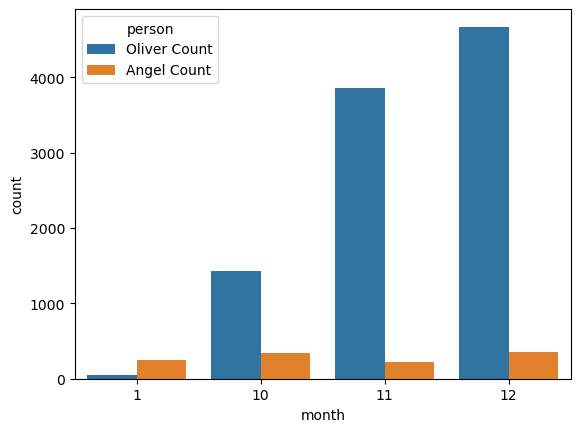

In [60]:
sns.barplot(data = melted, x = "month", y = "count", hue = "person")

Now we have a graph comparing the two datasets. The melt function was very useful in seperating the data in a way which could differentiate the person, month, and count of each row. The melt operator is very useful when your dataframe is not in a format which the graph can interpret easily, not just for bar graphs.